In [1]:
# imports
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# load data
train_data = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv')
test_data = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/test_V2.csv')

X = train_data.drop('winPlacePerc', axis=1)
Y = train_data['winPlacePerc']

In [ ]:
with pd.option_context('display.max_columns', None):
    display(train_data)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.000,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.040,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.000,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.000,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.000,0,0,49.75,2,0,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,1029,0,0,0.00,1873,squad-fpp,29,28,-1,0,1292.0000,0,0.000,0,0,1019.00,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,0,0,0,0.00,1435,solo,93,93,1501,0,0.0000,0,0.000,0,0,81.70,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,0,0,0,0.00,1321,squad-fpp,28,28,1500,0,0.0000,0,2.184,0,0,788.70,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,0,2,1,98.50,1373,squad-fpp,26,25,1418,2,0.0000,0,0.000,0,0,2748.00,8,0,0.8000


# EDA

| **Step**                      | **What to Do**                                                                                                                           | **Why It Matters**                                     | **Tip / Tools**                                                            |
| ----------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------ | -------------------------------------------------------------------------- |
| **1. Initial Inspection**     | • Check shape, dtypes, head/tail<br>• Summary stats (mean, median, std, unique counts)                                                   | Understand data structure and spot anomalies early     | `df.info()`, `df.head()`, `df.describe()`                                  |
| **2. Data Quality Check**     | • Detect duplicates<br>• Identify missing values and encoding issues<br>• Find inconsistencies                                           | Avoid skewed analysis due to poor data                 | `df.duplicated()`, `df.isnull()`, `missingno`                              |
| **3. Univariate Exploration** | • Plot histograms/density for numeric<br>• Box plots for outliers<br>• Bar charts for categories                                         | Reveal distributions, skewness, and anomalies          | `sns.histplot()`, `sns.boxplot()`, `df.value_counts()`                     |
| **4. Bivariate Analysis**     | • Scatter/pair plots for numeric<br>• Heatmap of correlations<br>• Countplots for category combos                                        | Uncover relationships and multicollinearity            | `sns.scatterplot()`, `sns.heatmap()`, `sns.countplot()`                    |
| **5. Missing & Outliers**     | • Heatmap/matrix for missingness<br>• Box/violin plots for continuous outliers                                                           | Guides decisions on cleaning and transformations       | `missingno.matrix()`, `sns.violinplot()`                                   |
| **6. Data Cleaning**          | • Impute or drop missing values<br>• Remove duplicates<br>• Standardize formats & resolve inconsistencies<br>• Detect and treat outliers | Prepares data for reliable modeling                    | `SimpleImputer`, `df.drop_duplicates()`, `df.fillna()`, `z‑score` or `IQR` |
| **7. Transform & Encode**     | • Scale numeric (standard/min–max)<br>• Encode categoricals (one-hot, label, ordinal)<br>• Convert types (date, category)                | Ensures features are compatible with model assumptions | `StandardScaler`, `MinMaxScaler`, `pd.get_dummies()`                       |
| **8. Feature Engineering**    | • Create features (ratios, datetime parts)<br>• Drop redundant features (via correlation/domain knowledge)                               | Boosts model performance and reduces noise             | `df.corr()`, predicate logic, domain expertise                             |
| **9. Document & Iterate**     | • Log all transformations & decisions<br>• Revisit steps based on new findings                                                           | Promotes reproducibility and ensures thoroughness      | Code comments, data notebooks, changelogs                                  |


**Your Final Outcome:**

By the end of **EDA**, you should have:

* A comprehensive understanding of your data's quality, structure, and characteristics. 
* Clear documentation of data issues and their potential impacts. 
* A preprocessing strategy based on your findings. 
* Initial hypotheses about which features might be most important. 
* A sense of what modeling approaches might work best given your data's properties.

*The key insight is that EDA isn't just about checking boxes - it's about building intuition that will guide every subsequent decision in your machine learning pipeline. The distribution analysis is just the foundation for this deeper understanding.*

## Initial inspection

In [13]:
train_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [ ]:
display(train_data.info())
display(train_data.describe())

## Checking data quality

In [ ]:
# Duplicates
train_data.duplicated('Id').value_counts()

In [ ]:
# Nans
display(train_data.isna().sum())

## Univariant exploration

**Why Check Data Distribution?**

* Understanding the nature of your data: Is it normally distributed, skewed, bimodal? This tells you about the underlying processes that generated your data and helps you choose appropriate modeling techniques.

* Identifying potential issues: Extreme skewness, unexpected peaks, or gaps in the distribution can signal data quality problems, measurement errors, or important business insights.

* Informing preprocessing decisions: The distribution shape directly impacts what transformations or scaling methods you'll need later.

**What Should Alarm You?**

* Extreme skewness: If your data is heavily skewed, many machine learning algorithms will struggle. Linear regression, for example, assumes normally distributed residuals.

* Unexpected modes: Multiple peaks might indicate your data actually represents different populations that should be analyzed separately.

* Impossible values - Negative ages, dates in the future, or values outside expected ranges suggest data quality issues.

* Too many zeros or missing patterns - This might indicate systematic data collection problems or business rules you need to understand.

**Should You Fix It Immediately?**

Not necessarily. During EDA, your primary goal is to **understand and document** what you're seeing. Don't rush to transform data until you understand why it looks the way it does. Sometimes what appears to be a "problem" is actually valuable information about your domain.

However, you should definitely code up your observations and potential solutions for later use.

### Target data

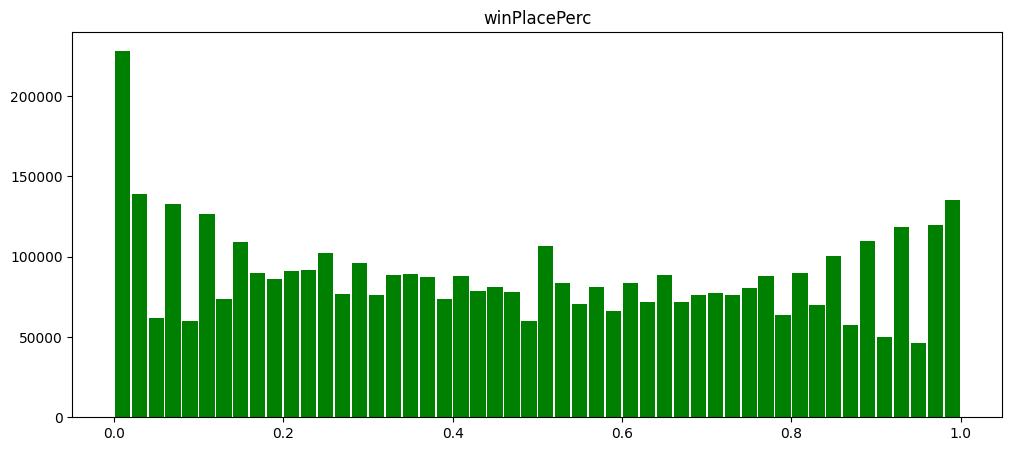

In [4]:
# check how our target data looks like

plt.figure(figsize=(12,5))
plt.hist(train_data['winPlacePerc'], bins=50, color='green', rwidth=0.90)
plt.title("winPlacePerc")
plt.show()

### Data Visualization

In [ ]:
# check our data, except out target

# Set figure size
fig, axes = plt.subplots(nrows=3, ncols=len(X.columns)//3, figsize=(20, 10))
axes = axes.flatten()

# Loop through each column and plot distribution
for i, column in enumerate(X.columns):
    sns.histplot(X[column], kde=True, ax=axes[i], bins=20)
    axes[i].set_title(f"Distribution of {column}")

# Hide empty subplots if columns are fewer
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

### Check normal distribution

| **Method**                             | **Description**                                                                                | **Pros** 👍                                                                                                                                                    | **Cons** ⚠️                                                                              | **Typical Use Case**                    | **Practical Example**                                      |
| -------------------------------------- | ---------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------- | --------------------------------------- | ---------------------------------------------------------- |
| **🌟 Shapiro‑Wilk Test**               | Tests whether a sample comes from a normal distribution using order statistics.                | ✅ Highly powerful, especially for small-to-medium samples; widely available in `scipy`, R| ⚠️ Overly sensitive on large N; limited to continuous data; may flag trivial deviations  | Pre-testing before t-tests, regressions | Checking normality of residuals in regression (N ≈ 30–500) |
| **🔍 Anderson‑Darling Test**           | Gives more weight to tails; compares empirical vs theoretical distribution across whole range. | ✅ Sensitive to tail differences; stronger alternative to K‑S                                                                                                   | ⚠️ Requires distribution‑specific critical values; less intuitive; software-dependent    | Goodness-of-fit in full-range stats     | Testing residual normality including tail behavior         |
| **⚖️ Kolmogorov‑Smirnov (Lilliefors)** | Nonparametric; measures max deviation between empirical & theoretical CDF.                     | ✅ Simple; exact test when distribution known; works with small samples                                                                                         | ⚠️ Less sensitive in tails; wrong if parameters are estimated; often misused             | Quick sanity check; nonparametric tests | Comparing sample distribution to known normal CDF          |

In [ ]:
shapiro_test, p_value = stats.shapiro(train_data['damageDealt'])
kolmo_test, p_value_kolmo = stats.kstest(train_data['damageDealt'], 'norm')

# If our p_value is smaller than 0.05, we could reject null hypothesis and in this case reject that our data follow standard distribution
print(f"Shapiro - {shapiro_test}, {p_value} Kolmogorov - {kolmo_test}, {p_value_kolmo}")

Shapiro - 0.7325563066256384, 1.2327946025335427e-199 Kolmogorov - 0.7185073944791855, 0.0


## Bivariate Analysis

### Correlation

| **Method**       | **What It Does**                                                          | **When to Use**                                                                                                 | **Pros** 👍                                                                    | **Cons** ⚠️                                                            | **Example**                                                                                                                                                                        |
| ---------------- | ------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------ | ---------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Pearson**      | Measures *linear* relationship strength between two continuous variables. | Both variables are interval/ratio, approximately **normally distributed**, relationship is expected to be linear. | Simple to compute; interprets magnitude & direction of *linear* correlation.   | **Sensitive to outliers**, assumes normality and homoscedasticity.     | Checking correlation between height and weight of adults|
| **Spearman** (ρ) | Measures *monotonic* relationship via ranked data.                        | Data is ordinal or **not normally distributed**, or relationship is non-linear but monotonic.                       | Robust to outliers, non-parametric, handles ordinal and rank data.             | Rank-based: less sensitive to magnitude changes, may lose information. | Ranking of students' performance across two tests                                                                                                                                  |
| **Kendall** (τ)  | Measures ordinal association by comparing concordant/discordant pairs.    | Ordinal data, small samples, many ties, or when requiring a conservative estimate.                              | More **conservative**, interpretable via *pair probability*, robust with ties. | Slightly slower to compute, may be less intuitive.                     | Comparing reviewers’ ranked preferences for a set of items          

<br>
<br>

|**r(rho) Value**  | **Strength**      | **Description**                       | **When to Use**                               | **Quick Example**                             |
| ----------------- | ----------------- | ------------------------------------- | --------------------------------------------- | --------------------------------------------- |
| **±0.80 to 1.00** | 🌟 Very Strong    | Almost perfect monotonic relationship | When predictors are highly aligned            | Age and years of work experience (ρ = 0.85)   |
| **±0.60 to 0.79** | ✅ Strong          | Clear and meaningful association      | When variables show a consistent trend        | Temperature vs. ice cream sales (r ≈ 0.70)    |
| **±0.40 to 0.59** | ✔️ Moderate       | Noticeable but moderate dependency    | When moderate predictive power is expected    | Reading hours vs. grades (r ≈ 0.50)           |
| **±0.20 to 0.39** | ⚠️ Weak           | Slight monotonic relationship         | When relationship exists but with variability | Social media time vs. stress level (ρ ≈ 0.30) |
| **0.00 to 0.19**  | 🚫 Very Weak/None | Essentially no monotonic correlation  | When variables are mostly independent         | Shoe size vs. favorite movie rating (r ≈ 0)   |
                                                                                                               |

In [ ]:
rho, p_value = stats.spearmanr(train_data['damageDealt'], train_data['winPlacePerc'])
print(f'Correlation between feature and y: {rho} and p_value - {p_value}')

# Visualizing
# plt.scatter(train_data['damageDealt'], train_data['winPlacePerc'], label='All data', alpha=0.5)
# plt.scatter(train_data['damageDealt'], train_data['winPlacePerc'], color='red', label='Outliers', edgecolors='black')
# plt.xlabel('Feature')
# plt.ylabel('Y')
# plt.legend()
# plt.title('Correlation between outliers and y')
# plt.show()

Correlation between feature and y: 0.44859106232490664 and p_value - 0.0


## Checking outliers/Missing Values

| **Method**                     | **Description**                                                            | **Pros**                                                      | **Cons**                                                               | **Practical Example**                              | **Use Cases**                                                |                     |
| ------------------------------ | -------------------------------------------------------------------------- | ------------------------------------------------------------- | ---------------------------------------------------------------------- | -------------------------------------------------- | ------------------------------------------------------------ | ------------------- |
| **Z-Score**                    | Measures how many standard deviations a data point is from the mean.       | Simple to implement; effective for normally distributed data. | Assumes normality; sensitive to extreme outliers.                      | Identifying unusually high test scores in a class. | Univariate outlier detection in normally distributed data.   |                     |
| **Interquartile Range (IQR)**  | Identifies outliers as points beyond 1.5×IQR from Q1 or Q3.                | Non-parametric; robust to non-normal distributions.           | Not suitable for multimodal distributions; limited to univariate data. | Spotting outliers in housing prices.               | Univariate outlier detection in skewed or non-normal data.   |                     |
| **Isolation Forest**           | Randomly partitions data to isolate anomalies quickly.                     | Efficient for large datasets; handles high-dimensional data.  | May struggle with clustered anomalies; randomness can affect results.  | Detecting anomalies in server log data.            | Anomaly detection in large-scale, high-dimensional datasets. |                     |

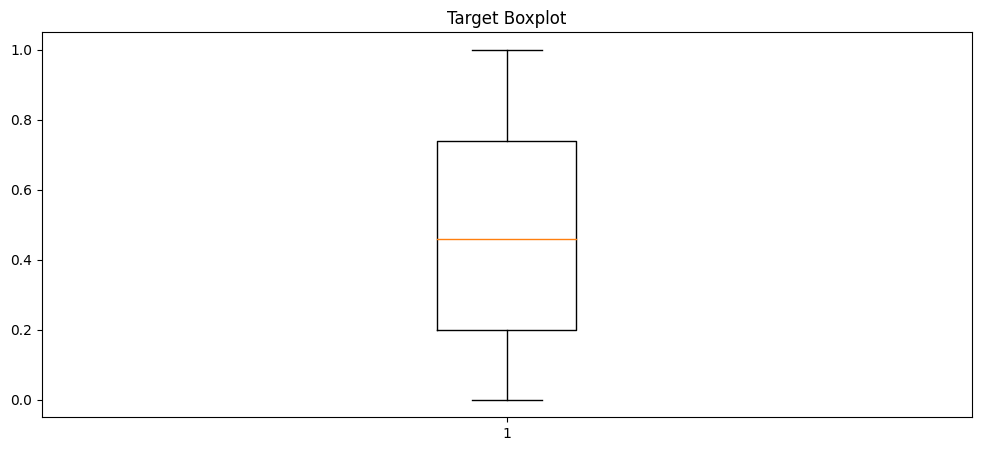

In [36]:
# Check box plot for outliners and distribution

plt.figure(figsize=(12, 5))
plt.boxplot(train_data['winPlacePerc'])
plt.title('Target Boxplot')
plt.show()

In [31]:
def check_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    IQR = Q3 - Q1

    lower_band = Q1 - 1.5 * IQR
    upper_band = Q3 + 1.5 * IQR

    print(f'IQR - {IQR}\nlower band - {lower_band}, upper band - {upper_band}')

    df = df[(df < lower_band) | (df > upper_band)]
    df_lower = df[df < lower_band]
    df_upper = df[df > upper_band]

    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df)
    plt.title(f"Outliers in {df.name}")
    plt.show()

    return df, df_lower, df_upper

In [ ]:
# Isolation Forest
outliers_forest = pd.DataFrame()

iso_forest = IsolationForest(contamination=0.1, random_state=42)
outliers_forest['Outlier_ISO'] = iso_forest.fit_predict(train_data[['damageDealt']])
outliers_forest['Outlier_ISO'] = outliers_forest['Outlier_ISO'].apply(lambda x: 'Outlier' if x == -1 else 'Normal')

IQR - 186.0
lower band - -279.0, upper band - 465.0


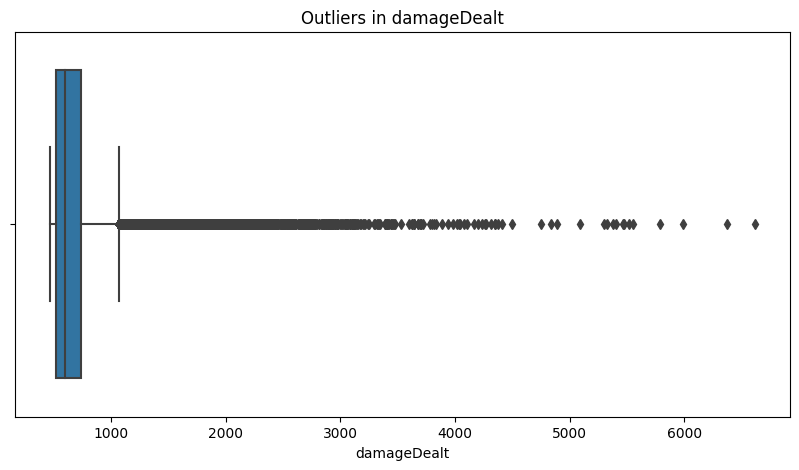

In [33]:
outliers, lower, upper = check_outliers(train_data['damageDealt'])

In [ ]:
# NaN values visualization

nan_counts = train_data.isna().sum()

# Plot bar chart
plt.figure(figsize=(20, 10))
nan_counts.plot(kind='bar', color='red', edgecolor='black')
plt.title("Missing Values Per Column")
plt.xlabel("Columns")
plt.ylabel("Count of NaNs")
plt.xticks(rotation=45)
plt.show()

## Data cleaning

In [ ]:
# drop unimportant values
train_data.drop(['Id', 'groupId', 'matchId'], axis=1, inplace=True)

# remove nan values
train_data.dropna(inplace=True)

## Data transformation and encoding

In [ ]:
# encode string values to ints
train_data['matchType'], mapping = pd.factorize(train_data['matchType'])
match_type = {value: index for value, index in enumerate(mapping)}

## Feature Engineering

# Modeling

## **XGBoost**

### **XGBoost most important parameters**
| Parameter | Description | Under/Overfitting Impact | Priority | Typical Values | When to Adjust | Key Notes |
|-----------|-------------|-------------------------|----------|----------------|----------------|-----------|
| **n_estimators** | Number of boosting rounds (trees) | More trees → overfitting risk<br>Too few → underfitting | 🔴 HIGH | 100-1000 | Always tune first with early stopping | Use early stopping to find optimal point. Start with 100-500 |
| **max_depth** | Maximum depth each tree can grow | Deeper → overfitting (complex patterns)<br>Shallow → underfitting (too simple) | 🔴 HIGH | 3-8 | If model too simple/complex | Most important complexity control. 6+ for complex data, 3-4 for simple |
| **learning_rate** | Shrinkage applied to each tree | Lower → reduces overfitting<br>Higher → faster learning, overfitting risk | 🔴 HIGH | 0.01-0.3 | Balance with n_estimators | Lower rate + more trees = better generalization. 0.1 is good start |
| **reg_alpha (L1)** | L1 regularization on leaf weights | Higher → less overfitting<br>Promotes feature sparsity | 🟡 MEDIUM | 0-10 | Many irrelevant features | Creates sparse models. Good for feature selection |
| **reg_lambda (L2)** | L2 regularization on leaf weights | Higher → less overfitting<br>Smooths extreme weights | 🟡 MEDIUM | 1-10 | Model overfitting | Default 1 is often good. Increase if still overfitting after other tuning |
| **subsample** | Fraction of training samples per tree | Lower → less overfitting<br>Too low → underfitting | 🟡 MEDIUM | 0.7-1.0 | Large datasets, overfitting | Introduces randomness. 0.8-0.9 often optimal |
| **colsample_bytree** | Fraction of features used per tree | Lower → less overfitting<br>Reduces feature correlation | 🟡 MEDIUM | 0.7-1.0 | High-dimensional data | Especially useful with correlated features. Try 0.8 first |
| **min_child_weight** | Min sum of weights required for leaf | Higher → prevents overfitting<br>Requires statistical significance | 🟢 LOW | 1-10 | Imbalanced/noisy data | Higher values for imbalanced data. Start with 1, increase if overfitting |
| **gamma** | Min loss reduction required for split | Higher → more conservative<br>Prevents unnecessary splits | 🟢 LOW | 0-5 | Trees too deep/complex | Acts as pre-pruning. Increase if max_depth alone isn't enough |
| **scale_pos_weight** | Balance positive/negative class weights | Adjusts class prediction bias | 🔴 HIGH* | neg_samples/pos_samples | Imbalanced classification | *Only for imbalanced data. Essential parameter for class imbalance |

In [ ]:
# Convert data to DMatrix for XGBoost API

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

# Train baseline XGBoost classifier
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.1,
    "max_depth": 6,
    "seed": 42
}
bst = xgb.train(params, dtrain, num_boost_round=50, 
                early_stopping_rounds=5, 
                evals=[(dtrain, "train"), (dtest, "test")], verbose_eval=True)

'''
# 4. Evaluate
y_pred_prob = bst.predict(dtest)
y_pred = y_pred_prob.argmax(axis=1)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=iris.target_names))

# 5. Hyperparameter tuning with scikit-learn API
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", seed=42)
param_grid = {
    "max_depth": [2, 3, 4],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [50, 100, 150],
    "subsample": [0.6, 0.8, 1.0]
}
grid = GridSearchCV(xgb_clf, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

# 6. Feature importance
best = grid.best_estimator_
importances = best.feature_importances_
plt.barh(iris.feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()
'''

# Deep Learning

## Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [ ]:
# General syntax:

# Creating tensors
x = torch.tensor([1, 2, 3, 4, 5])  # From list
y = torch.zeros(3, 4)              # Zeros tensor
z = torch.randn(2, 3)              # Random normal distribution
w = torch.ones_like(z)             # Same shape as z, filled with ones

# Tensor properties
print(f"Shape: {z.shape}")         # torch.Size([2, 3])
print(f"Data type: {z.dtype}")     # torch.float32
print(f"Device: {z.device}")       # cpu or cuda

# Mathematical operations
a = torch.tensor([1., 2., 3.])
b = torch.tensor([4., 5., 6.])

addition = a + b                    # Element-wise addition
multiplication = a * b              # Element-wise multiplication
dot_product = torch.dot(a, b)       # Dot product
matrix_mult = torch.mm(a.unsqueeze(0), b.unsqueeze(1))  # Matrix multiplication

# Reshaping and indexing
tensor = torch.randn(4, 4)
reshaped = tensor.view(2, 8)        # Reshape (must maintain total elements)
sliced = tensor[:2, 1:3]           # Slicing like NumPy

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move tensors to GPU
tensor_gpu = tensor.to(device)
# or
tensor_gpu = tensor.cuda()         # If you're sure GPU is available

# Always ensure tensors are on the same device for operations

In [ ]:
# Pytroch Classes
class Iris_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class perceptron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(perceptron, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        output = self.layers(x)
        return output

In [ ]:
# prepare dataset:
iris_data = pd.read_csv('/kaggle/input/iris/Iris.csv')

iris_x = iris_data.drop(['Species', 'Id'], axis=1)

iris_y = iris_data['Species']
iris_y, target = iris_y.factorize()
target_idx = {values: idx for values, idx in enumerate(target)}

# split data to train and test datasets
x_train, x_test, y_train, y_test = train_test_split(iris_x, iris_y, train_size=0.8)

# convert data into tensors
x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

x_test = torch.tensor(x_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


# prepare test and train datasets
train_dataset = Iris_Dataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)

test_dataset = Iris_Dataset(x_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)

In [ ]:
flower_classifier = perceptron(4, 32, 3)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(flower_classifier.parameters(), lr=0.001)

num_epochs = 100
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

flower_classifier.to(device)

for epoch in range(num_epochs):
    # Training phase
    flower_classifier.train()
    running_loss = 0.0
    
    for data, labels in tqdm(train_dataloader, desc='Training loop'):
        # Move inputs and labels to the device
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = flower_classifier(data)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(dataloader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    flower_classifier.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader, desc='Validation loop'):
            # Move inputs and labels to the device
            data, labels = data.to(device), labels.to(device)
         
            outputs = flower_classifier(data)
            loss = loss_func(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(dataloader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

## Loss functions

* **Regression**

| **Loss Function**                  | **Explanation**                                                                   | **Use Case**                                                           | **Outlier Sensitivity** |   |
| ---------------------------------- | --------------------------------------------------------------------------------- | ---------------------------------------------------------------------- | ----------------------- | - |
| **Mean Squared Error (MSE)**       | Penalizes larger errors more than smaller ones by squaring the differences.       | Regression tasks where large errors are undesirable.                   | High                    |   |
| **Mean Absolute Error (MAE)**      | Treats all errors equally by taking the absolute difference.                      | Regression tasks requiring robustness to outliers.                     | Low                     |   |
| **Huber Loss**                     | Combines MSE and MAE; behaves like MSE for small errors and MAE for large errors. | Regression tasks with outliers; balances sensitivity.                  | Medium                  |   |
| **Root Mean Squared Error (RMSE)** | Square root of MSE; maintains the same units as the target variable.              | Regression tasks where interpretability in target units is beneficial. | High                    |   |


* **Classification**

| **Loss Function**                   | **Explanation**                                                                              | **Use Case**                                            | **Outlier Sensitivity** |   |
| ----------------------------------- | -------------------------------------------------------------------------------------------- | ------------------------------------------------------- | ----------------------- | - |
| **Binary Cross-Entropy (Log Loss)** | Measures the performance of a classification model outputting probabilities between 0 and 1. | Binary classification problems.                         | High                    |   |
| **Categorical Cross-Entropy**       | Generalization of binary cross-entropy for multi-class classification problems.              | Multi-class classification with one-hot encoded labels. | High                    |   |
| **Hinge Loss**                      | Used for "maximum-margin" classification, primarily with Support Vector Machines (SVMs).     | Binary classification with SVMs.                        | Medium                  |   |


* **Other**

| **Loss Function**                               | **Explanation**                                                                                                                 | **Use Case**                                                            | **Outlier Sensitivity** |   |
| ----------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------- | ----------------------- | - |
| **Kullback-Leibler Divergence (KL Divergence)** | Measures how one probability distribution diverges from a second, expected probability distribution.                            | Comparing probability distributions; e.g., in variational autoencoders. | High                    |   |
| **Cosine Similarity Loss**                      | Measures the cosine of the angle between two non-zero vectors; assesses similarity.                                             | Text classification and tasks involving high-dimensional vector spaces. | Low                     |   |
| **Triplet Loss**                                | Ensures that the distance between an anchor and a positive example is less than the distance to a negative example by a margin. | Face recognition, metric learning tasks.                                | Medium                  |   |

<br>

When to Use:
<br>

**MSE**: Use when you want to heavily penalize large errors (e.g., forecasting, financial modeling).

**MAE**: Use when all errors should be treated equally, and outliers shouldn't dominate (e.g., evaluating models with noisy data).

**RMSE**: Best when you need a balance between MSE and MAE, keeping errors in the same scale as the original data (e.g., climate modeling, sensor measurements).